In [81]:
!pip install kagglehub
!pip install wordcloud

In [82]:
import kagglehub
import shutil
import os
import pandas as pd

In [83]:
# Download latest version
path = kagglehub.dataset_download("aadyasingh55/twitter-emotion-classification-dataset")
print("Path to dataset files:", path)

100%|██████████| 22.3M/22.3M [00:23<00:00, 976kB/s] 

Extracting files...


Path to dataset files: C:\Users\itsre\.cache\kagglehub\datasets\aadyasingh55\twitter-emotion-classification-dataset\versions\1


In [84]:
# move the dataset to this directory
destination_path = os.path.join(os.getcwd(), os.path.basename(path))
shutil.move(path, destination_path)
print("Dataset moved to:", destination_path)

Dataset moved to: g:\WORK\JEFF\TwitterClassification\1



## Loading data

In this section, we load the Twitter Emotion Classification dataset. The dataset is downloaded using the `kagglehub` library and moved to the current working directory. We then read the Parquet file into a pandas DataFrame for further analysis.


In [85]:
# Construct the full path to the Parquet file
parquet_file_path = os.path.join(destination_path, 'train-00000-of-00001.parquet')

# Read the Parquet file into a DataFrame
dataset = pd.read_parquet(parquet_file_path)

# Display the first few rows of the DataFrame
dataset.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


## Data Cleaning and Preprocessing

In [86]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB
None


In [87]:
print("Missing values per column:\n", dataset.isnull().sum())

Missing values per column:
 text     0
label    0
dtype: int64


In [88]:
print("Label distribution:\n", dataset['label'].value_counts())


Label distribution:
 label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


In [89]:
# Define the mapping of labels to emotion names
label_mapping = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

# Map the labels to emotion names
dataset['emotion'] = dataset['label'].map(label_mapping)

# Display the updated DataFrame
dataset.head()


,text,label,emotion
0,i feel awful about it too because it s my job ...,0,Sadness
1,im alone i feel awful,0,Sadness
2,ive probably mentioned this before but i reall...,1,Joy
3,i was feeling a little low few days back,0,Sadness
4,i beleive that i am much more sensitive to oth...,2,Love


In [90]:
initial_duplicates = dataset.duplicated(subset=['text', 'label']).sum()
print(f"Initial duplicate rows based on text and label: {initial_duplicates}")
dataset.drop_duplicates(subset=['text', 'label'], inplace=True)

Initial duplicate rows based on text and label: 686


In [91]:
remaining_duplicates = dataset.duplicated(subset=['text']).sum()
print(f"Remaining duplicate rows based on text: {remaining_duplicates}")
dataset.drop_duplicates(subset=['text'], inplace=True)

Remaining duplicate rows based on text: 22301


In [92]:
print("Missing values after cleaning:\n", dataset.isnull().sum())


Missing values after cleaning:
 text       0
label      0
emotion    0
dtype: int64


In [93]:
# check for null values'
print(dataset.isnull().sum())

text       0
label      0
emotion    0
dtype: int64


In [94]:
# # Add a new column for text length, which might help in analysis
dataset['text_length'] = dataset['text'].apply(len)
dataset.head()

,text,label,emotion,text_length
0,i feel awful about it too because it s my job ...,0,Sadness,112
1,im alone i feel awful,0,Sadness,21
2,ive probably mentioned this before but i reall...,1,Joy,152
3,i was feeling a little low few days back,0,Sadness,40
4,i beleive that i am much more sensitive to oth...,2,Love,99


In [95]:
print(dataset[['label', 'text_length']].describe())

               label    text_length
count  393822.000000  393822.000000
mean        1.510639      96.899203
std         1.474540      56.159354
min         0.000000       2.000000
25%         0.000000      53.000000
50%         1.000000      86.000000
75%         3.000000     128.000000
max         5.000000     830.000000


## Data Visualization

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

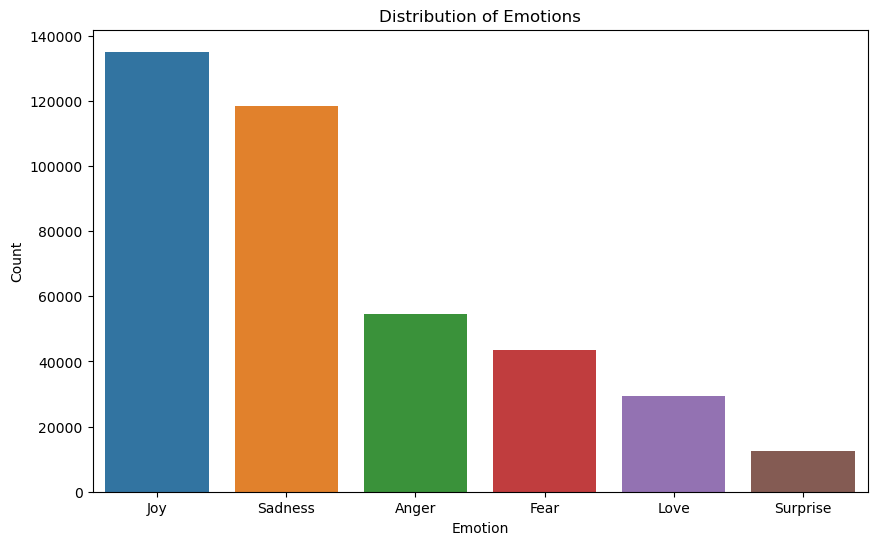

In [97]:
# Plot the count of each emotion category
plt.figure(figsize=(10, 6))
sns.countplot(data=dataset, x='emotion', order=dataset['emotion'].value_counts().index)
plt.title("Distribution of Emotions")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

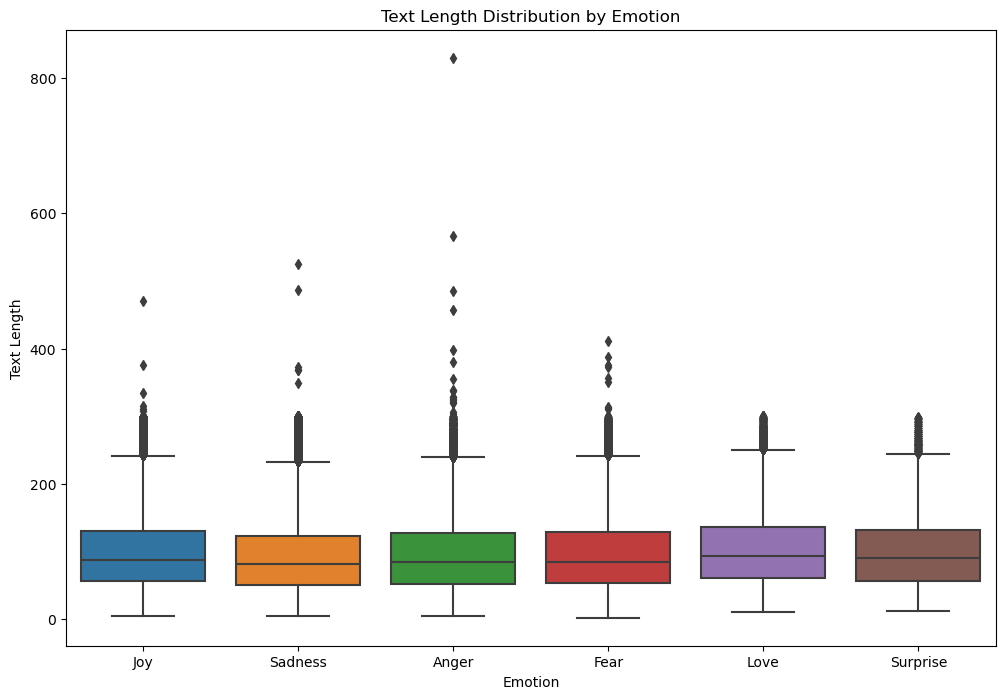

In [98]:
# Create a box plot to show the distribution of text length by emotion
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset, x='emotion', y='text_length', order=dataset['emotion'].value_counts().index)
plt.title("Text Length Distribution by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Text Length")
plt.show()


c:\Users\itsre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


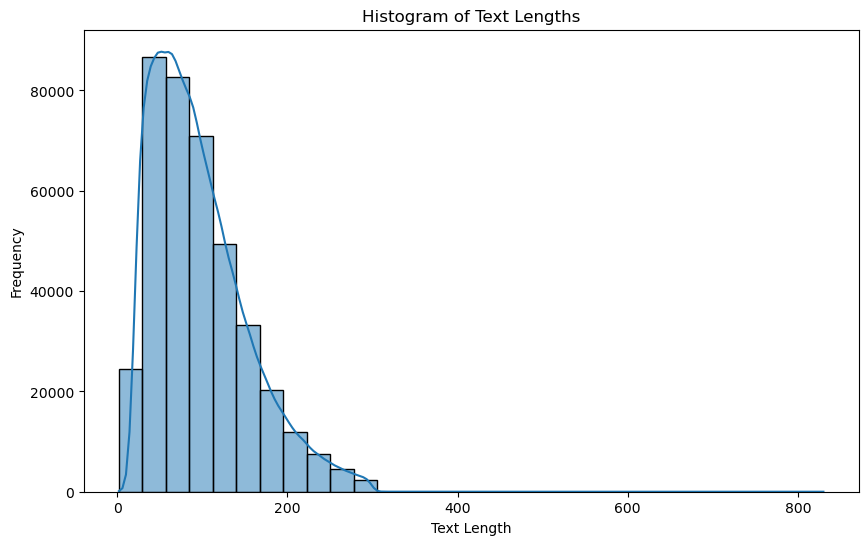

In [99]:
# Plot a histogram of text lengths to understand the overall distribution
plt.figure(figsize=(10, 6))
sns.histplot(dataset['text_length'], bins=30, kde=True)
plt.title("Histogram of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

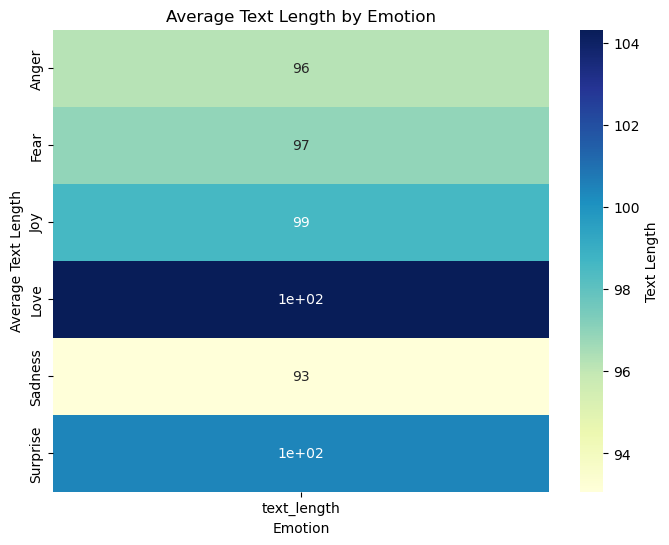

In [100]:
# Pivot the data to prepare for correlation heatmap
emotion_length_corr = dataset.groupby('emotion')['text_length'].mean().reset_index()
emotion_length_corr = emotion_length_corr.pivot_table(index="emotion", values="text_length")

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(emotion_length_corr, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Text Length'})
plt.title("Average Text Length by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Average Text Length")
plt.show()

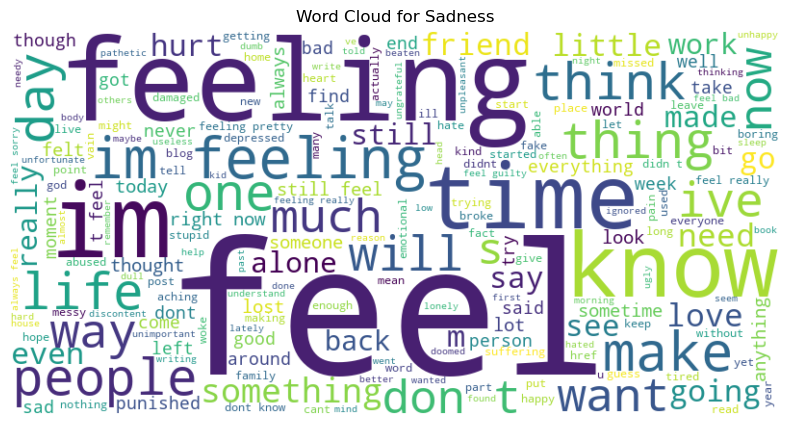

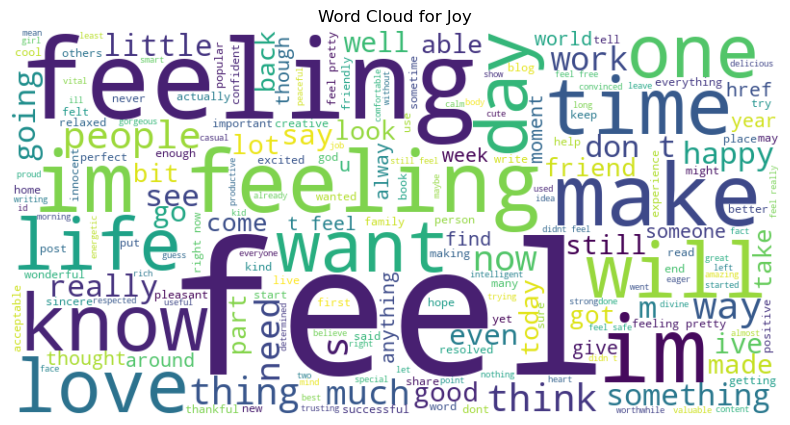

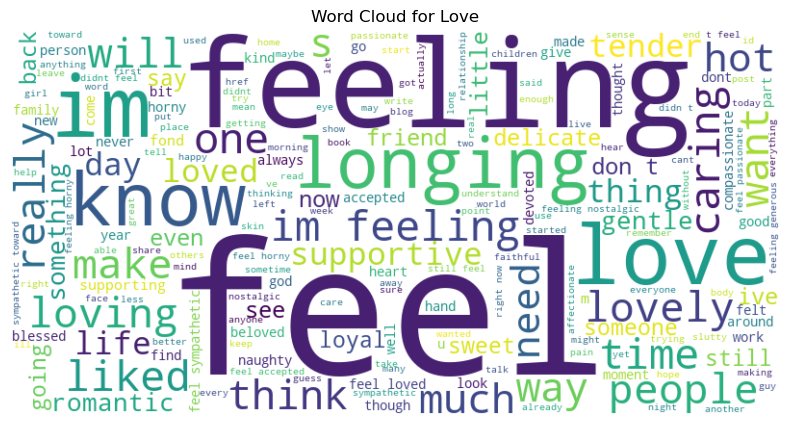

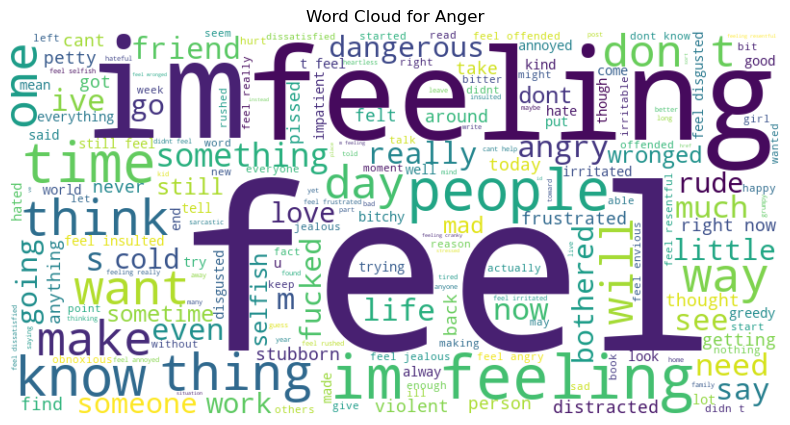

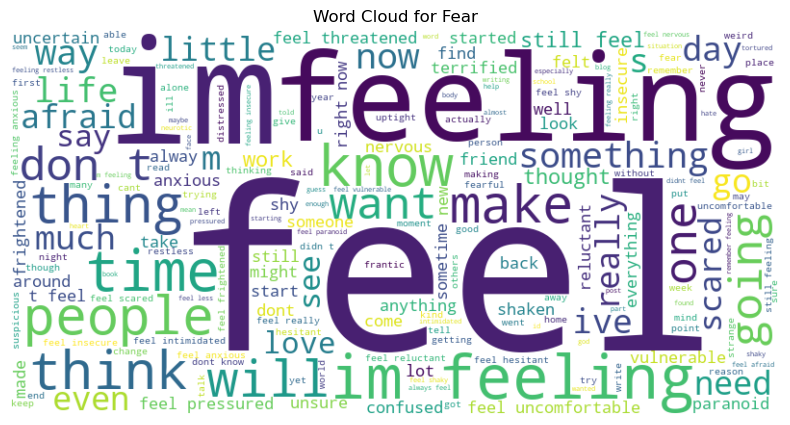

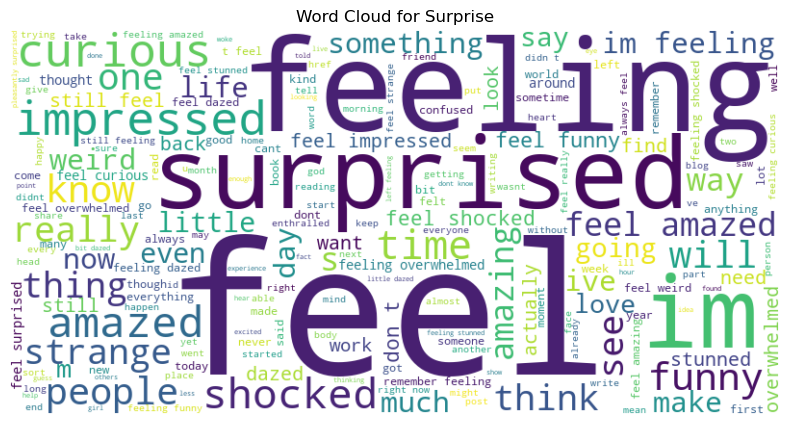

In [101]:
from wordcloud import WordCloud

# Generate and display a word cloud for each emotion
for emotion in dataset['emotion'].unique():
    text = ' '.join(dataset[dataset['emotion'] == emotion]['text'])
    wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {emotion}")
    plt.show()
    